<a href="https://colab.research.google.com/github/carizadias/Student_Recognizer/blob/main/ProjetoFinal_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Recognition**

In [ ]:
# Importação de bibliotecas necessárias
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
#from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Preparação dos Dados**

In [ ]:
#Definir diretórios das imagens
train_dir='/content/drive/MyDrive/ai/dataset/train'
validation_dir='/content/drive/MyDrive/ai/dataset/validation'

In [ ]:
# Parâmetros de imagem
img_height, img_width = 224, 224
batch_size = 100

In [ ]:
# Data augmentation para as imagens de treinamento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Rescalonamento para imagens de validação
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1520 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


## **Treinamento dos Dados**

In [ ]:
# Carregar o modelo EfficientNetB0 pré-treinado, excluindo a camada de saída
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Adicionar novas camadas
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [ ]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# Congelar as camadas da base do modelo (EfficientNetB0)
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [ ]:
# Compilar o modelo
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ai/model/best_model.h5', save_best_only=True)

In [ ]:
# Resumo do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [ ]:
# Treinamento o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
15/15 [==============================] - ETA: 0s - loss: 12.3559 - accuracy: 0.6415

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 347s 24s/step - loss: 12.3559 - accuracy: 0.6415 - val_loss: 2.1699 - val_accuracy: 0.8033
Epoch 2/10
15/15 [==============================] - 66s 4s/step - loss: 1.9192 - accuracy: 0.6979 - val_loss: 0.8830 - val_accuracy: 0.7900
Epoch 3/10
15/15 [==============================] - 66s 4s/step - loss: 0.6737 - accuracy: 0.7486 - val_loss: 0.5818 - val_accuracy: 0.7967
Epoch 4/10
15/15 [==============================] - 67s 4s/step - loss: 0.5631 - accuracy: 0.7831 - val_loss: 0.5314 - val_accuracy: 0.8000
Epoch 5/10
15/15 [==============================] - 69s 5s/step - loss: 0.5906 - accuracy: 0.7831 - val_loss: 0.4894 - val_accuracy: 0.8100
Epoch 6/10
15/15 [==============================] - 68s 5s/step - loss: 0.5825 - accuracy: 0.7873 - val_loss: 0.5049 - val_accuracy: 0.8100
Epoch 7/10
15/15 [==============================] - 58s 4s/step - loss: 0.5427 - accuracy: 0.7838 - val_loss: 0.5336 - val_accuracy: 0.7933
Epoch 8/10
15/15 [==========

In [ ]:
model.save('/content/drive/MyDrive/ai/model/cariza_classifier_model.h5')

In [ ]:
# Avaliação do modelo no conjunto de validação
val_loss, val_acc = model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')


3/3 [==============================] - 7s 2s/step - loss: 0.5118 - accuracy: 0.7967
Validation Loss: 0.5118271112442017
Validation Accuracy: 0.79666668176651


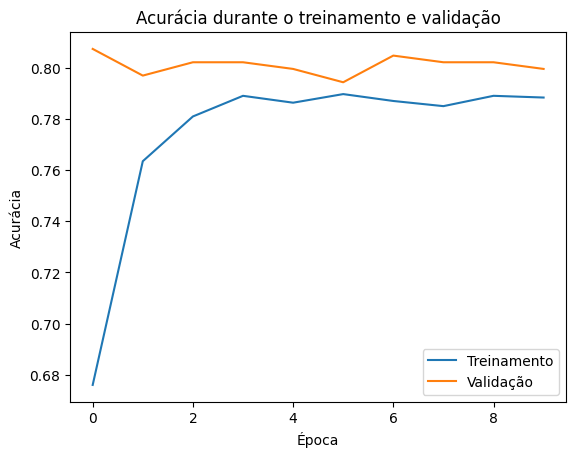

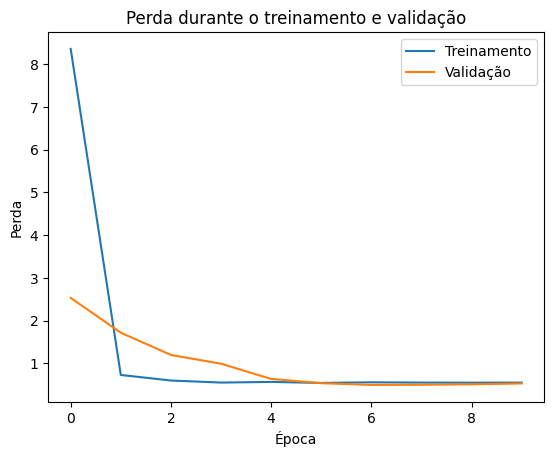

In [ ]:
import matplotlib.pyplot as plt

# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar a perda
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda durante o treinamento e validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()


In [ ]:
#carregando modelo criado
model_path = '/content/drive/MyDrive/ai/model/cariza_classifier_model2.h5'
model = load_model(model_path)

## **Predição**

1/1 [==============================] - 0s 24ms/step


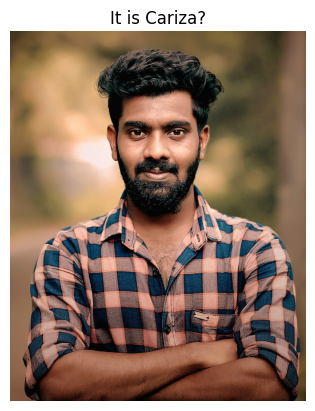

Predição: Não Cariza


In [ ]:
# Função para processar a imagem
def process_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho da imagem para 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar uma dimensão para o batch
    img_array = img_array / 255.0  # Normalizar a imagem
    return img_array

# Caminho para a imagem de teste
test_img_path = '/content/drive/MyDrive/ai/test/man.jpg'  # Substitua pelo caminho da sua imagem de teste

# Processamento da imagem de teste
test_img = process_image(test_img_path)

# Fazer a predição
prediction = model.predict(test_img)

# Mostrar predição
plt.imshow(image.load_img(test_img_path))
plt.axis('off')
plt.title('It is Cariza?')
plt.show()

print(f'Predição: {"Cariza" if prediction[0] > 0.5 else "Não Cariza"}')

1/1 [==============================] - 1s 1s/step


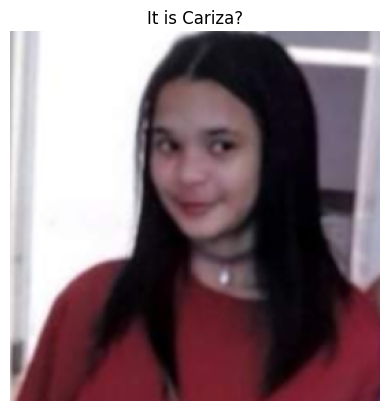

Predição: Cariza


In [ ]:
# Função para processar a imagem
def process_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho da imagem para 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Adicionar uma dimensão para o batch
    img_array = img_array / 255.0  # Normalizar a imagem
    return img_array

# Caminho para a imagem de teste
test_img_path = '/content/drive/MyDrive/ai/test/ProfilePicturePhoto.png'  # Substitua pelo caminho da sua imagem de teste

# Processamento da imagem de teste
test_img = process_image(test_img_path)

# Fazer a predição
prediction = model.predict(test_img)

# Mostrar predição
plt.imshow(image.load_img(test_img_path))
plt.axis('off')
plt.title('It is Cariza?')
plt.show()

print(f'Predição: {"Cariza" if prediction[0] > 0.5 else "Não Cariza"}')